In [1]:
import numpy as np
import random
import itertools
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf
import os

C:\Users\Philip\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
class gameOb():
    def __init__(self,coordinates,size,intensity,channel,reward,name):       
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name

In [8]:
class gameEnv():
    def __init__(self, size):
        self.sizeX = size
        self.sizeY = size
        self.actions = 4
        self.objects = []
        a = self.reset()
        plt.imshow(a, interpolation="nearest")
        
    def reset(self):
        self.objects = []
        hero = gameOb(self.newPosition(),1,1,2,None,'hero')
        self.objects.append(hero)
        
        goal = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(goal)
        
        hole = gameOb(self.newPosition(),1,1,0,-1,'fire')
        self.objects.append(hole)
        
        goal2 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(goal2)
        
        hole2 = gameOb(self.newPosition(),1,1,0,-1,'fire')
        self.objects.append(hole2)
        
        goal3 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(goal3)
        
        goal4 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(goal4)
        
        state = self.renderEnv()
        self.state = state
        
        return state
    
    def moveChar(self,direction):
        hero = self.objects[0]
        heroX = hero.x
        heroY = hero.y
        
        if direction == 0 and hero.y >= 1:
            hero.y -= 1
        if direction == 1 and hero.y <= self.sizeY - 2:
            hero.y += 1
        if direction == 2 and hero.x >= 1:
            hero.x -= 1
        if direction == 3 and hero.x <= self.sizeX - 2:
            hero.x += 1
            
    def newPosition(self):
        iterables = [ range(self.sizeX), range(self.sizeY)]
        points = []
        
        for t in itertools.product(*iterables):
            points.append(t)
        currentPositions = []
        
        for objectA in self.objects:
            if(objectA.x, objectA.y) not in currentPositions:
                currentPositions.append((objectA.x, objectA.y))
                
        for pos in currentPositions:
            points.remove(pos)
        
        location = np.random.choice(range(len(points)), replace=False)
        return points[location]
    
    def checkGoal(self):
        others = []
        for obj in self.objects:
            if obj.name == 'hero':
                hero = obj
            else:
                others.append(obj)
        
        for other in others:
            if hero.x == other.x and hero.y == other.y:
                slef.objects.remove(other)
                if other.reward == 1:
                    self.objects.append(gameOb(self.newPosition(),1,1,1,1,'goal'))
                else:
                    self.objects.append(gameOb(self.newPosition(),1,1,0,-1,'fire'))
                    
                return other.reward,False
        return 0.0,False
    
    def renderEnv(self):
        a = np.ones([self.sizeY+2,self.sizeX+2,3])
        a[1:-1,1:-1,:] = 0
        hero = None
        
        for item in self.objects:
            a[item.y+1:item.y+item.size+1, item.x+1:item.x+item.size+1, item.channel] = item.intensity
            
        b = scipy.misc.imresize(a[:,:,0], [84,84,1], interp='nearest')
        c = scipy.misc.imresize(a[:,:,1], [84,84,1], interp='nearest')
        d = scipy.misc.imresize(a[:,:,2], [84,84,1], interp='nearest')
        a = np.stack([b,c,d],axis=2)
        
        return a
    
    def step(slef,action):
        self.moveChar(action)
        reward,done = self.checkGoal()
        state = self.renderEnv()
        return state,reward,done

C:\Users\Philip\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\Philip\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\Philip\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


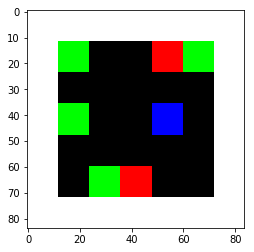

In [9]:
env = gameEnv(size=5)

In [17]:
class Qnetwork():
    def __init__(self,h_size):
        self.scalerInput = tf.placeholder(tf.float32, shape=[None,21168])
        self.imageIn = tf.reshape(self.scalerInput, shape=[-1,84,84,3])
        
        self.conv1 = tf.contrib.layers.convolution2d(inputs=self.imageIn, num_outputs=32,
                                                     kernel_size=[8,8], stride=[4,4], padding='VALID', biases_initializer=None)
        self.conv2 = tf.contrib.layers.convolution2d(inputs=self.conv1, num_outputs=64,
                                                     kernel_size=[4,4], stride=[2,2], padding='VALID', biases_initializer=None)
        self.conv3 = tf.contrib.layers.convolution2d(inputs=self.conv2, num_outputs=64,
                                                     kernel_size=[3,3], stride=[1,1], padding='VALID', biases_initializer=None)
        self.conv4 = tf.contrib.layers.convolution2d(inputs=self.conv3, num_outputs=512,
                                                     kernel_size=[7,7], stride=[1,1], padding='VALID', biases_initializer=None)
        
        #將conv4拆成DQN的Advantage Function和Value Function
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3) #第二個參數是要拆幾段，第三個是要拆第幾個維度
        self.streamA = tf.contrib.layers.flatten(self.streamAC) 
        self.streamV = tf.contrib.layers.flatten(self.streamVC)
        
        #創建Fully connect
        self.AW = tf.Variable(tf.random_normal([h_size//2, env.actions]))   #Action數量
        self.VW = tf.Variable(tf.random_normal([h_size//2, 1]))
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VW)
        
        #Q值
        self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage, reduction_indices=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout, 1)
        
        self.targetQ = tf.placeholder(tf.float32,shape=[None])
        self.actions = tf.placeholder(tf.int32,shape=[None])
        self.action_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32)
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.action_onehot), reduction_indices=1)
        
        #loss計算targetQ跟Q的均方誤差
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [13]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer)) - self.buffer_size] = []
            
        self.buffer.extend(experience)
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)), [size,5])

In [21]:
def processState(states):
    return np.reshape(states,[211628])
    
#更新Targer DQN
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
        
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx + total_vars//2].assign((var.value() * tau) + \
                                                                ((1 - tau) * tfVars[idx+total_vars//2].value())))
    return op_holder
    
def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)

In [22]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 10000#How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)
init = tf.global_variables_initializer()

trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables,tau)